# Gaussian Process using Tanimoto kernel

In [50]:
from __future__ import division
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rpy2 import robjects
from rpy2.robjects.packages import importr
from pandas import Series, DataFrame
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.metrics import r2_score
from IPython.core.pylabtools import figsize

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

%matplotlib inline
figsize(16, 8)

# Load and adjust data

In [51]:
df_std1 = pd.read_csv('../data/std1_mh_11_pubchem.csv', keep_default_na=False)
df_std2 = pd.read_csv('../data/std2_mh_11_pubchem.csv', keep_default_na=False)

df_std1 = df_std1[['Name', 'InChI', 'Dil_1_1']]
df_std2 = df_std2[['Name', 'InChI', 'Dil_1_1']]

max_intensity = df_std1['Dil_1_1'].max()
df_std1['Dil_1_1'] = df_std1['Dil_1_1'] / max_intensity
df_std1['Dil_1_1'] = np.log(df_std1['Dil_1_1'])

max_intensity = df_std2['Dil_1_1'].max()
df_std2['Dil_1_1'] = df_std2['Dil_1_1'] / max_intensity
df_std2['Dil_1_1'] = np.log(df_std2['Dil_1_1'])

df_std1['mol'] = df_std1['InChI'].apply(lambda x: Chem.MolFromInchi(x))
df_std2['mol'] = df_std2['InChI'].apply(lambda x: Chem.MolFromInchi(x))

In [52]:
# X_train, X_test, y_train, y_test = cross_validation.train_test_split(
#     df_std1, df_std1[['Dil_1_1']], test_size=0.4)

X_train = df_std1
y_train = df_std1[['Dil_1_1']]

X_test = df_std2
y_test = df_std2[['Dil_1_1']]

print("Number of metabolites (training):", len(X_train))
print("Number of metabolites (testing):", len(X_test))

Number of metabolites (training): 64
Number of metabolites (testing): 47


In [53]:
# Import RChemCpp
rchemcpp = importr("Rchemcpp")

In [58]:
def execute_tanimoto(X_train, y_train, X_test, alg_params):
    # Create SDF files that will be used for the kernels
    for df, file_name in zip([X_train, X_test], ['_std1_train.sdf', '_std1_test.sdf']):
        w = Chem.SDWriter('../data/' + file_name)
        try:
            for mol in df['mol']:
                w.write(mol)
            w.flush()
        finally:
            w.close()
            
    train_sdf_path = os.path.abspath('../data/_std1_train.sdf')
    test_sdf_path = os.path.abspath('../data/_std1_test.sdf')
    
    # Compute kernel
    rK = rchemcpp.sd2gramSpectrum(train_sdf_path, **alg_params)
    rKx = rchemcpp.sd2gramSpectrum(train_sdf_path, test_sdf_path, **alg_params)
    rK_ = rchemcpp.sd2gramSpectrum(test_sdf_path, **alg_params)
    
    K = np.array(rK)
    Kx = np.array(rKx)
    K_ = np.array(rK_)
                  
    # Gaussian Process
    s = 0.00005 # noise variance.

    L = np.linalg.cholesky(K + s * np.eye(np.size(K, axis=0)))

    # compute the mean at our test points.
    Lk = np.linalg.solve(L, Kx)
    mu = np.dot(Lk.T, np.linalg.solve(L, y_train))

    # compute the variance at our test points.
    s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
    s = np.sqrt(s2)
    
    return mu, s

def plot_results(y_test, mu, s, title='New Model'):
    r2 = r2_score(y_test, mu)

    plt.xlabel('Measured')
    plt.ylabel('New Predicted')
    plt.scatter(y_test, mu)
    
    ylim = plt.ylim()
    plt.errorbar(y_test, mu, yerr=s, fmt='o')
    plt.ylim(*ylim)
    
    xlim = plt.xlim()
    plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
    plt.xlim(*xlim)
    
    plt.grid(True)
    plt.title(title + ' $R^2$={:.4f}'.format(r2))

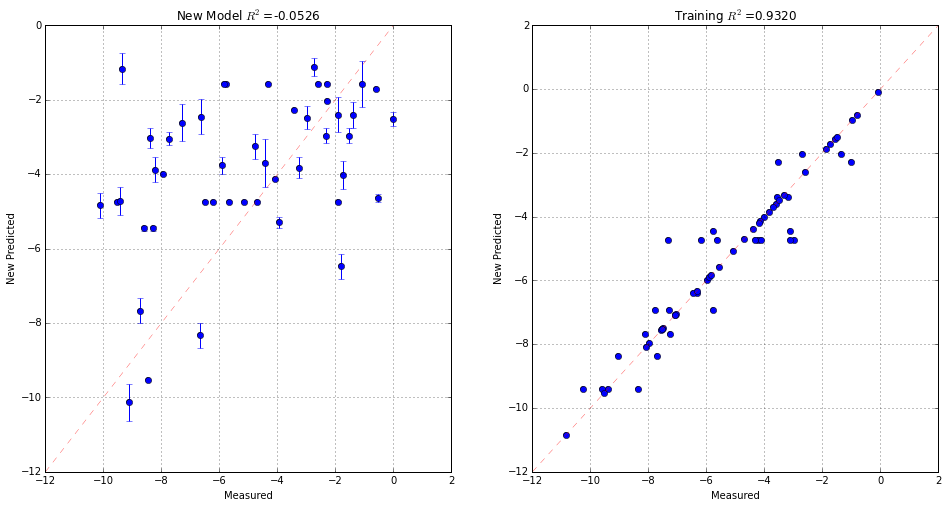

In [59]:
params = {
    'kernelType': 'tanimoto', # other option: minmaxTanimoto
    'silentMode': True, # default: False
    'depthMax': 2 # default: 3
}

mu, s = execute_tanimoto(X_train, y_train, X_test, params)
train_mu, train_s = execute_tanimoto(X_train, y_train, X_train, params)

plt.subplot(1, 2, 1)
plot_results(y_test['Dil_1_1'], mu, s)
plt.subplot(1, 2, 2)
plot_results(y_train['Dil_1_1'], train_mu, train_s, title='Training')

plt.show()